In [47]:
import os
import json
import random
from collections import defaultdict
import pandas as pd
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import time
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import vit_b_32, ViT_B_32_Weights

In [48]:
# --- 1. Setup Paths and Parameters ---
# TODO: Update these paths to your local directory structure
dataset_path = './InfraredSolarModules/images'  # e.g., '/content/PV_Images/'
metadata_path = './InfraredSolarModules/module_metadata.json' # Assumes the json is in the same directory

TARGET_COUNT = 2500



In [49]:
# --- 2. Load Metadata and Corrected Image Path Logic ---
print("Loading metadata and image paths...")
# Load the JSON file for class labels
try:
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
except FileNotFoundError:
    print(f"Error: The file '{metadata_path}' was not found. Please ensure it's in the correct directory.")
    # Exit gracefully if the metadata is missing
    exit()


# Group all full image paths by their anomaly_class label
image_paths = defaultdict(list)
skipped_files = 0
for img_name in os.listdir(dataset_path):
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # The key in the JSON is the filename without the extension
        base_name = os.path.splitext(img_name)[0]

        # Find the label from the metadata using the base filename
        if base_name in metadata:
            label = metadata[base_name]['anomaly_class']
            full_path = os.path.join(dataset_path, img_name)
            image_paths[label].append(full_path)
        else:
            print(f"Warning: '{img_name}' not found in metadata. Skipping.")
            skipped_files += 1

print(f"Finished scanning. Found images for {len(image_paths)} classes. Skipped {skipped_files} files.")
print("-" * 30)




Loading metadata and image paths...
Finished scanning. Found images for 12 classes. Skipped 0 files.
------------------------------


In [50]:
# --- 3. Initial Dataset Summary ---
initial_counts = {label: len(paths) for label, paths in image_paths.items()}
# Ensure the DataFrame is created correctly, even if no images were found
if not initial_counts:
    print("Error: No images were loaded. Please check your 'dataset_path'.")
    exit()

summary_df = pd.DataFrame(list(initial_counts.items()), columns=['Class', 'Images Before Balancing'])
print("Initial dataset summary:")
print(summary_df.to_string(index=False))
print("-" * 30)




Initial dataset summary:
         Class  Images Before Balancing
    Cell-Multi                     1288
    No-Anomaly                    10000
          Cell                     1877
   Diode-Multi                      175
     Shadowing                     1056
    Vegetation                     1639
         Diode                     1499
Offline-Module                      827
      Cracking                      940
       Soiling                      204
      Hot-Spot                      249
Hot-Spot-Multi                      246
------------------------------


In [51]:
# --- 4. Define Augmentation and Pre-processing ---
# Unsharpening filter to be applied to all images first
unsharp_filter = ImageFilter.UnsharpMask(radius=2, percent=150)

# Augmentation pipeline for up-sampling minority classes
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
])




In [52]:
# --- 5. Balance the Dataset ---
final_images = []
final_labels = []

print(f"Balancing dataset to {TARGET_COUNT} images per class...")

for label, paths in image_paths.items():
    current_count = len(paths)
    print(f"Processing class: '{label}' ({current_count} images)")

    # Unsharpen all original images for the class first
    original_images_unsharpened = [Image.open(p).convert("RGB").filter(unsharp_filter) for p in paths]

    if current_count > TARGET_COUNT:
        # Down-sample: Randomly select images
        selected_images = random.sample(original_images_unsharpened, TARGET_COUNT)
        final_images.extend(selected_images)
        final_labels.extend([label] * TARGET_COUNT)

    elif current_count < TARGET_COUNT:
        # Up-sample: Use augmentation to create new images
        augmented_images = []
        num_to_generate = TARGET_COUNT - current_count
        for i in range(num_to_generate):
            # Pick a random original image to augment
            random_image = random.choice(original_images_unsharpened)
            augmented_image = augmentation_transform(random_image)
            augmented_images.append(augmented_image)

        # Combine original unsharpened images with new augmented ones
        all_class_images = original_images_unsharpened + augmented_images
        final_images.extend(all_class_images)
        final_labels.extend([label] * TARGET_COUNT)

    else: # current_count == TARGET_COUNT
        # Just use the unsharpened images
        final_images.extend(original_images_unsharpened)
        final_labels.extend([label] * TARGET_COUNT)

print("\nDataset balancing complete.")




Balancing dataset to 2500 images per class...
Processing class: 'Cell-Multi' (1288 images)
Processing class: 'No-Anomaly' (10000 images)
Processing class: 'Cell' (1877 images)
Processing class: 'Diode-Multi' (175 images)
Processing class: 'Shadowing' (1056 images)
Processing class: 'Vegetation' (1639 images)
Processing class: 'Diode' (1499 images)
Processing class: 'Offline-Module' (827 images)
Processing class: 'Cracking' (940 images)
Processing class: 'Soiling' (204 images)
Processing class: 'Hot-Spot' (249 images)
Processing class: 'Hot-Spot-Multi' (246 images)

Dataset balancing complete.


In [53]:
# --- 6. Final Augmented Dataset Summary ---
final_counts = {label: final_labels.count(label) for label in summary_df['Class']}
summary_df['Images After Balancing'] = summary_df['Class'].map(final_counts)

print("\n--- Final Dataset Summary ---")
print(summary_df.to_string(index=False))


--- Final Dataset Summary ---
         Class  Images Before Balancing  Images After Balancing
    Cell-Multi                     1288                    2500
    No-Anomaly                    10000                    2500
          Cell                     1877                    2500
   Diode-Multi                      175                    2500
     Shadowing                     1056                    2500
    Vegetation                     1639                    2500
         Diode                     1499                    2500
Offline-Module                      827                    2500
      Cracking                      940                    2500
       Soiling                      204                    2500
      Hot-Spot                      249                    2500
Hot-Spot-Multi                      246                    2500



Displaying 5 sample images from the final dataset...


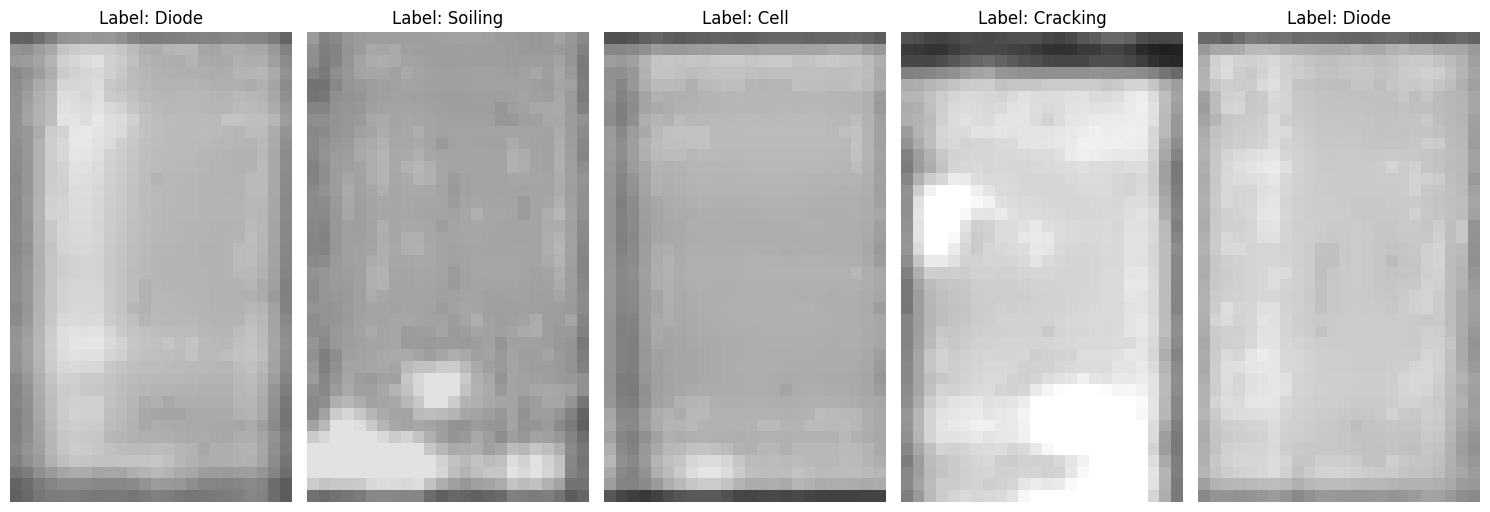

In [54]:
# --- 7. Show 5 Sample Images ---
print("\nDisplaying 5 sample images from the final dataset...")

# Create a combined list and shuffle it to show diverse samples
combined = list(zip(final_images, final_labels))
random.shuffle(combined)

plt.figure(figsize=(15, 5))
for i in range(5):
    if i < len(combined):
        image, label = combined[i]
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [55]:
# --- 1. Setup & Hyperparameters ---
NUM_EPOCHS = 4 # A small number for demonstration; increase for better results
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [56]:
# --- 2. Dataset and DataLoader Preparation ---
# Ensure final_images and final_labels from the previous step are available
try:
    _ = final_images
    _ = final_labels
except NameError:
    print("Error: 'final_images' and 'final_labels' not found.")
    print("Please run the data preparation script from question 1 first.")
    exit()

# Get the transformations required by the ViT model
weights = ViT_B_32_Weights.DEFAULT
vit_transforms = weights.transforms()

# Create a mapping from class names to integer indices
class_to_idx = {name: i for i, name in enumerate(sorted(list(set(final_labels))))}
idx_to_class = {i: name for name, i in class_to_idx.items()}
NUM_CLASSES = len(class_to_idx)
print(f"Found {NUM_CLASSES} classes.")

# Custom PyTorch Dataset
class PVDataset(Dataset):
    def __init__(self, images, labels, transform, class_to_idx):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label_str = self.labels[idx]
        # Apply transformations
        image = self.transform(image)
        label_idx = self.class_to_idx[label_str]
        return image, label_idx

# Create the full dataset
full_dataset = PVDataset(final_images, final_labels, vit_transforms, class_to_idx)

# Define split sizes
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
print(f"Train set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

# Create DataLoaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
}
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Found 12 classes.
Train set: 21000 images
Validation set: 4500 images
Test set: 4500 images


In [57]:
# --- 3. Training and Evaluation Functions ---

def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, time_elapsed


def test_model(model):
    model.eval()
    running_corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            running_corrects += (preds == labels).sum().item()
    test_acc = running_corrects / total
    print(f'Test Accuracy: {test_acc:.4f}')
    return test_acc

In [58]:
# --- 4. Main Execution Block for Strategies ---
results = []

# --- Strategy 1: Fine-tune only the classifier head ---
print("\n--- STRATEGY 1: Fine-tuning the Classifier Head ---\n")
model_1 = vit_b_32(weights=ViT_B_32_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in model_1.parameters():
    param.requires_grad = False

# Replace the classifier head and unfreeze it
model_1.heads.head = nn.Linear(model_1.heads.head.in_features, NUM_CLASSES)
for param in model_1.heads.head.parameters():
    param.requires_grad = True

model_1 = model_1.to(DEVICE)
optimizer_1 = optim.AdamW(model_1.heads.head.parameters(), lr=LEARNING_RATE)
criterion_1 = nn.CrossEntropyLoss()

# Train and evaluate
trained_model_1, history_1, time_1 = train_model(model_1, criterion_1, optimizer_1)
test_acc_1 = test_model(trained_model_1)

results.append({
    'Strategy': '1. Head Only',
    'Training Time (s)': time_1,
    'Train Accuracy': history_1['train_acc'][-1],
    'Validation Accuracy': max(history_1['val_acc']),
    'Test Accuracy': test_acc_1
})

# --- Strategy 2: Fine-tune the entire model ---
print("\n--- STRATEGY 2: Fine-tuning the Entire Model ---\n")
model_2 = vit_b_32(weights=ViT_B_32_Weights.IMAGENET1K_V1)

# Replace the classifier head (all layers are trainable by default)
model_2.heads.head = nn.Linear(model_2.heads.head.in_features, NUM_CLASSES)
model_2 = model_2.to(DEVICE)
optimizer_2 = optim.AdamW(model_2.parameters(), lr=LEARNING_RATE)
criterion_2 = nn.CrossEntropyLoss()

# Train and evaluate
trained_model_2, history_2, time_2 = train_model(model_2, criterion_2, optimizer_2)
test_acc_2 = test_model(trained_model_2)

results.append({
    'Strategy': '2. Full Model',
    'Training Time (s)': time_2,
    'Train Accuracy': history_2['train_acc'][-1],
    'Validation Accuracy': max(history_2['val_acc']),
    'Test Accuracy': test_acc_2
})

# --- Strategy 3: Fine-tune last few transformer blocks + head ---
print("\n--- STRATEGY 3: Fine-tuning Last 2 Transformer Blocks + Head ---\n")
model_3 = vit_b_32(weights=ViT_B_32_Weights.IMAGENET1K_V1)
num_blocks_to_unfreeze = 2

# Freeze all layers
for param in model_3.parameters():
    param.requires_grad = False

# Unfreeze the last N transformer blocks
# The ViT architecture has 12 blocks in encoder.layers
for i in range(len(model_3.encoder.layers) - num_blocks_to_unfreeze, len(model_3.encoder.layers)):
    for param in model_3.encoder.layers[i].parameters():
        param.requires_grad = True

# Unfreeze the final layer normalization and the classifier head
model_3.heads.head = nn.Linear(model_3.heads.head.in_features, NUM_CLASSES)
for param in model_3.encoder.ln.parameters():
    param.requires_grad = True
for param in model_3.heads.head.parameters():
    param.requires_grad = True

model_3 = model_3.to(DEVICE)
# Create a list of parameters that require gradients for the optimizer
params_to_update = [p for p in model_3.parameters() if p.requires_grad]
optimizer_3 = optim.AdamW(params_to_update, lr=LEARNING_RATE)
criterion_3 = nn.CrossEntropyLoss()

# Train and evaluate
trained_model_3, history_3, time_3 = train_model(model_3, criterion_3, optimizer_3)
test_acc_3 = test_model(trained_model_3)

results.append({
    'Strategy': '3. Last 2 Blocks + Head',
    'Training Time (s)': time_3,
    'Train Accuracy': history_3['train_acc'][-1],
    'Validation Accuracy': max(history_3['val_acc']),
    'Test Accuracy': test_acc_3
})


--- STRATEGY 1: Fine-tuning the Classifier Head ---

Epoch 1/4
----------
train Loss: 2.4113 Acc: 0.1760
val Loss: 2.3071 Acc: 0.2580
Epoch 2/4
----------
train Loss: 2.2374 Acc: 0.2970
val Loss: 2.1721 Acc: 0.3318
Epoch 3/4
----------
train Loss: 2.1254 Acc: 0.3503
val Loss: 2.0804 Acc: 0.3516
Epoch 4/4
----------
train Loss: 2.0480 Acc: 0.3703
val Loss: 2.0141 Acc: 0.3753
Training complete in 4m 6s
Best val Acc: 0.3753
Test Accuracy: 0.3720

--- STRATEGY 2: Fine-tuning the Entire Model ---

Epoch 1/4
----------
train Loss: 1.5525 Acc: 0.4734
val Loss: 1.2293 Acc: 0.5727
Epoch 2/4
----------
train Loss: 1.0732 Acc: 0.6333
val Loss: 1.0129 Acc: 0.6449
Epoch 3/4
----------
train Loss: 0.8226 Acc: 0.7190
val Loss: 0.8272 Acc: 0.7184
Epoch 4/4
----------
train Loss: 0.6171 Acc: 0.7904
val Loss: 0.7309 Acc: 0.7433
Training complete in 5m 32s
Best val Acc: 0.7433
Test Accuracy: 0.7367

--- STRATEGY 3: Fine-tuning Last 2 Transformer Blocks + Head ---

Epoch 1/4
----------
train Loss: 1.6765

In [59]:
# --- 5. Display Final Results ---
print("\n--- Comparison of Fine-Tuning Strategies ---\n")
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


--- Comparison of Fine-Tuning Strategies ---

               Strategy  Training Time (s)  Train Accuracy  Validation Accuracy  Test Accuracy
           1. Head Only         246.122664        0.370333             0.375333       0.372000
          2. Full Model         331.897445        0.790429             0.743333       0.736667
3. Last 2 Blocks + Head         266.785536        0.705810             0.665556       0.669111
